In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

In [ ]:
df = pd.read_csv("/content/Groceries_dataset2.csv", encoding_errors='ignore')

In [ ]:
print("Shape:", df.shape)
print(df.head())

Shape: (38765, 3)
   Member_number        Date   itemDescription
0           1808  21-07-2015    tropical fruit
1           2552  05-01-2015        whole milk
2           2300  19-09-2015         pip fruit
3           1187  12-12-2015  other vegetables
4           3037  01-02-2015        whole milk


In [ ]:
print(df.info())

print(df.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38765 entries, 0 to 38764
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Member_number    38765 non-null  int64 
 1   Date             38765 non-null  object
 2   itemDescription  38765 non-null  object
dtypes: int64(1), object(2)
memory usage: 908.7+ KB
None
Member_number      0
Date               0
itemDescription    0
dtype: int64


In [ ]:
#Since, date was an object, we need to convert it into appropirate type

df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')
df['Date'].dt.year.value_counts().sort_values(ascending=False)

,count
Date,
2015,20488
2014,18277


In [ ]:
# using groupby to arrange the transactions according to member and date
#using ['itemDescription'].apply(list) to convert different transactions of a person at a specific data into a list

transactions_df = (df.groupby(['Member_number', 'Date'])['itemDescription'].apply(list).reset_index().rename(columns={'itemDescription': 'Items'}))
print(transactions_df.head())
print(f"\nTotal number of transactions: {len(transactions_df)}")

   Member_number       Date                                              Items
0           1000 2014-06-24                  [whole milk, pastry, salty snack]
1           1000 2015-03-15  [sausage, whole milk, semi-finished bread, yog...
2           1000 2015-05-27                         [soda, pickled vegetables]
3           1000 2015-07-24                     [canned beer, misc. beverages]
4           1000 2015-11-25                        [sausage, hygiene articles]

Total number of transactions: 14963


In [ ]:
# Using transactionEncoder to do one hot coding and getting basket_matrix

te = TransactionEncoder()
te_ary = te.fit(transactions_df['Items']).transform(transactions_df['Items'])
basket_matrix = pd.DataFrame(te_ary, columns=te.columns_)

In [ ]:
print("Basket shape:", basket_matrix.shape)
print(basket_matrix.iloc[:5, :10])

Basket shape: (14963, 167)
   Instant food products  UHT-milk  abrasive cleaner  artif. sweetener  \
0                  False     False             False             False   
1                  False     False             False             False   
2                  False     False             False             False   
3                  False     False             False             False   
4                  False     False             False             False   

   baby cosmetics   bags  baking powder  bathroom cleaner   beef  berries  
0           False  False          False             False  False    False  
1           False  False          False             False  False    False  
2           False  False          False             False  False    False  
3           False  False          False             False  False    False  
4           False  False          False             False  False    False  


In [ ]:
#applying appriori algorithm on basket_matrix and also counting support in numbers

frequent_itemsets = apriori(basket_matrix,min_support=0.01,use_colnames=True)

frequent_itemsets['support_count'] = (frequent_itemsets['support'] * len(basket_matrix))

frequent_itemsets = frequent_itemsets.sort_values(by='support',ascending=False).reset_index(drop=True)

print(frequent_itemsets.head(10))

    support            itemsets  support_count
0  0.157923        (whole milk)         2363.0
1  0.122101  (other vegetables)         1827.0
2  0.110005        (rolls/buns)         1646.0
3  0.097106              (soda)         1453.0
4  0.085879            (yogurt)         1285.0
5  0.069572   (root vegetables)         1041.0
6  0.067767    (tropical fruit)         1014.0
7  0.060683     (bottled water)          908.0
8  0.060349           (sausage)          903.0
9  0.053131      (citrus fruit)          795.0


In [ ]:
#generating rules from the frequent_itemsets
rules = association_rules(frequent_itemsets,metric='confidence',min_threshold=0.1)
rules = rules.sort_values(by='lift', ascending=False).reset_index(drop=True)
print(rules[['antecedents','consequents','support','confidence','lift']].head(10))

          antecedents   consequents   support  confidence      lift
0            (yogurt)  (whole milk)  0.011161    0.129961  0.822940
1        (rolls/buns)  (whole milk)  0.013968    0.126974  0.804028
2  (other vegetables)  (whole milk)  0.014837    0.121511  0.769430
3              (soda)  (whole milk)  0.011629    0.119752  0.758296


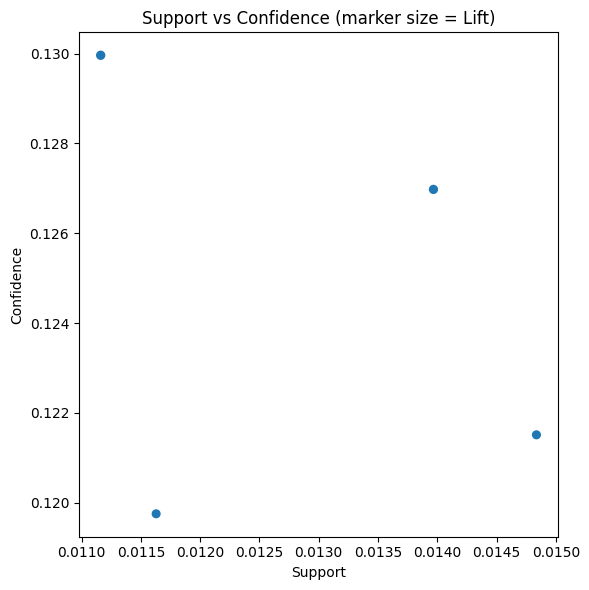

In [ ]:
plt.figure(figsize=(6, 6))
plt.scatter(rules['support'],rules['confidence'],s=rules['lift'] * 40)
plt.xlabel('Support')
plt.ylabel('Confidence')
plt.title('Support vs Confidence (marker size = Lift)')
plt.tight_layout()
plt.show()

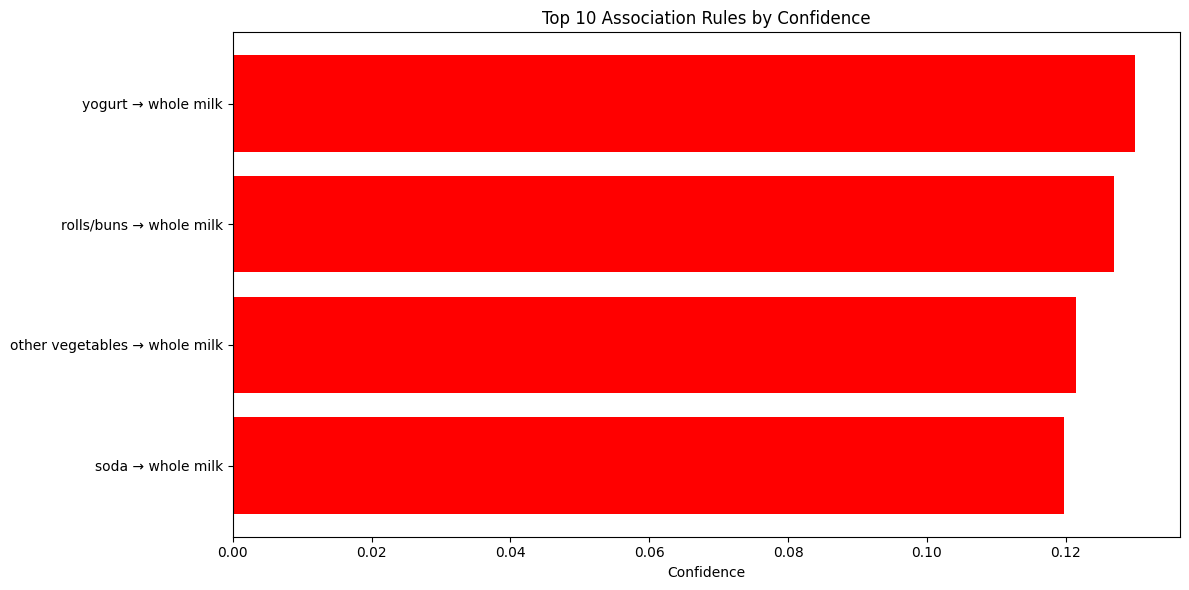

In [ ]:
#comparing different rules with their confidence

top_rules = rules.sort_values(by='confidence', ascending=False).head(10)
top_rules['rule'] = top_rules['antecedents'].apply(lambda x: ', '.join(list(x))) + ' → ' + \
                    top_rules['consequents'].apply(lambda x: ', '.join(list(x)))
plt.figure(figsize=(12, 6))
plt.barh(top_rules['rule'], top_rules['confidence'], color='red')
plt.xlabel('Confidence')
plt.title('Top 10 Association Rules by Confidence')
plt.gca().invert_yaxis()  # Highest confidence at the top
plt.tight_layout()
plt.show()

Interpretation and Use of Association Rules in Inventory Management:

The association rules found using the Apriori algorithm help us understand what items customers often buy together. For example, rules like "rolls/buns → whole milk" or "yogurt → whole milk" show that these items are commonly purchased as a pair. This can help improve inventory planning in many ways.First, such items can be kept close to each other in the store to make shopping easier and encourage customers to buy more. Second, the store can offer combo deals or discounts on these popular combinations to increase sales. Lastly, items that appear frequently in the rules should always be kept in stock to avoid running out. In short, these rules make inventory decisions more accurate and better suited to customer needs.
